# Историческая справка

Взглянем на временную линию развития нейросетей. Что происходило с 1986 по 2006 год?

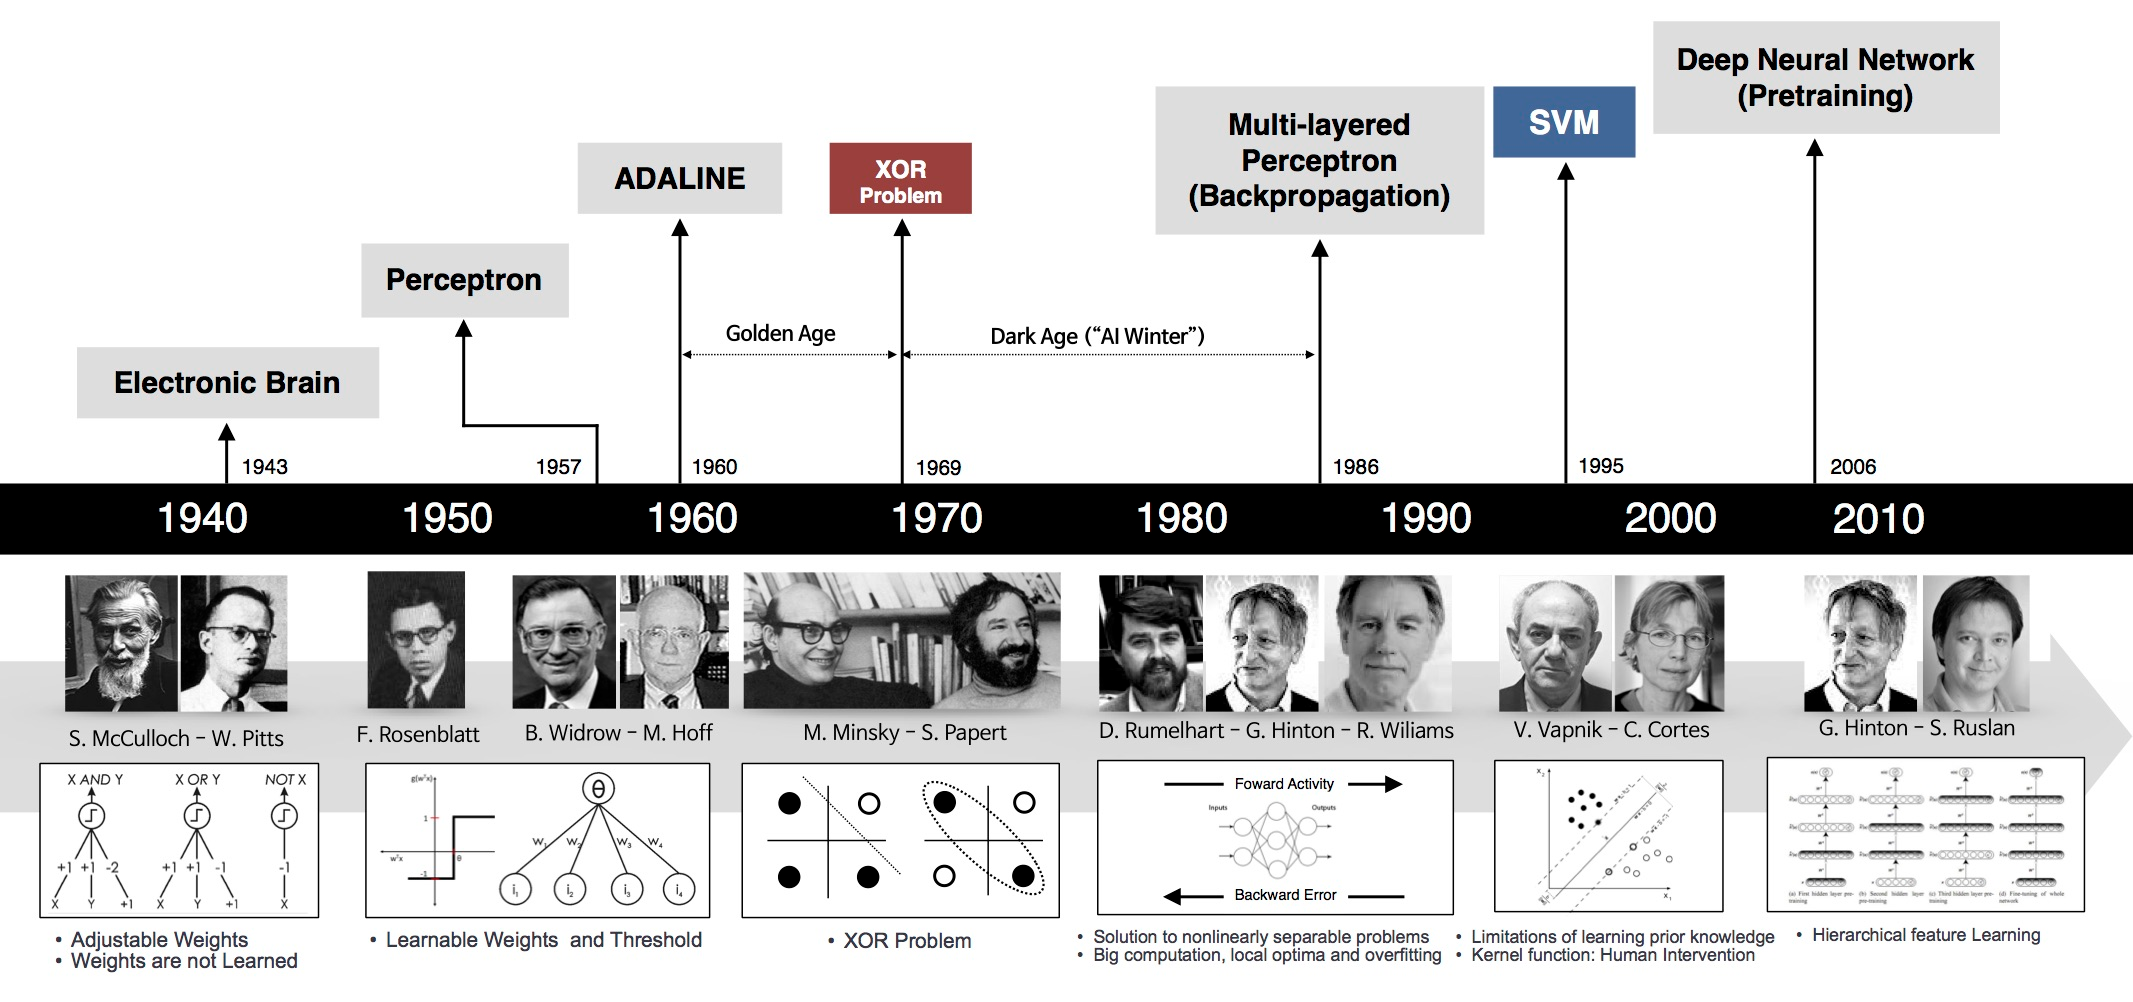


Если мы можем обучать глубокие нейронные сети на домашнем компьютере сейчас, почему нельзя было делать это 50 лет назад?

Ответ - не в скромной производительности компьютеров и недостатке данных для обучения(хотя и в них тоже), а в 3х фундаментальных проблемах обучения нейросетей:
1. Нестабильность градиентного спуска
2. Переобучение
3. Затухание градиентов

В рамках этого семинара будем работать с первой проблемой.

In [ ]:
# Стандартный импорт
import torch
import torch.nn as nn
import os
import sys
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tqdm

root_path = os.path.dirname(os.getcwd())
sys.path.append(root_path)

# 1. Улучшаем градиентный спуск

Мы уже сталкивались с некоторыми недостатками стохастического градиентного спуска, в частности:
- его склонностью "застревать" в локальных минимумах
- необходимостью тщательного подбора `learning_rate`
- низкой эффективностью на поздних этапах обучения

Поскольку стохастический градиентный спуск, как и все другие методы обновления параметров нейросетей, является прежде всего *методом оптимизации*, будем сравнивать эти методы на примере задачи нахождения минимума функции.

In [3]:
def plot_surface(w_grid, Z, ax2d=None, ax3d=None, cmap='viridis', grid=True):

    # 2D contour plot
    if ax2d != None:
        contour = ax2d.contourf(w_grid[..., 0], w_grid[..., 1], Z, 50, cmap=cmap)
        ax2d.get_figure().colorbar(contour)
        ax2d.set_xlabel('w1')
        ax2d.set_ylabel('w2')
        ax2d.set_aspect('equal')
        ax2d.grid(grid)

    # 3D surface plot
    if ax3d != None:
        ax3d.plot_surface(w_grid[..., 0], w_grid[..., 1], Z, cmap=cmap, edgecolor='none')
        ax3d.set_xlabel('w1')
        ax3d.set_ylabel('w2')
        

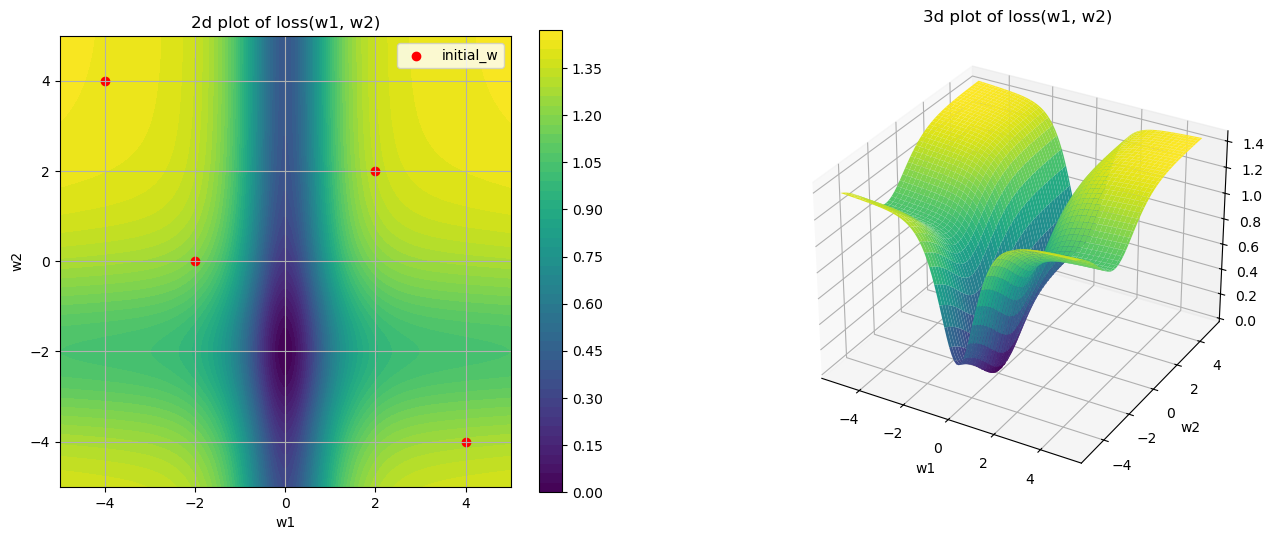

In [4]:
def loss(w):
    
    w1 = w[..., 0]
    w2 = w[..., 1]
    
    x1_loss = torch.tanh(w1) ** 2 + 0.01 * torch.abs(w1)
    x2_loss = 0.4*torch.tanh((w2+2.0)/2) ** 2

    return x1_loss + x2_loss

start_w = torch.tensor([[-4.0, 4.0],\
                   [2.0, 2.0],
                   [-2.0, 0.0],
                   [4.0, -4.0]])

w1 = torch.linspace(-5, 5, 100)
w2 = torch.linspace(-5, 5, 100)
w1, w2 = torch.meshgrid(w1, w2, indexing='ij')
W_grid = torch.stack([w1, w2], dim=-1)
Z = loss(W_grid)


fig = plt.figure(figsize=(16, 6))

ax2d = fig.add_subplot(1, 2, 1)
ax2d.set_title('2d plot of loss(w1, w2)')

ax3d = fig.add_subplot(1, 2, 2, projection='3d')
ax3d.set_title('3d plot of loss(w1, w2)')

plot_surface(W_grid, Z, ax2d=ax2d, ax3d=ax3d)

ax2d.scatter(start_w[:, 0], start_w[:, 1], color='red', label='initial_w')
ax2d.legend()

plt.show()


In [26]:
def validate_optimizers(\
          opt_dict,
          loss,
          initial_points,
          opt_pdict,
          nsteps=100
          ):
    
    history = {}

    for key in opt_dict.keys():

        history[key] = [None] * len(initial_points)

        for i, w_init in enumerate(initial_points):
            
            w = w_init.clone().detach()
            w.requires_grad = True

            opt = opt_dict[key](params=[w], **opt_pdict[key])

            history[key][i] = {'traj': [],  'loss': []}

            for step in range(nsteps+1):

                history[key][i]['traj'].append(w.clone().detach())
                
                loss_val = loss(w)

                if step != nsteps:
                    
                    loss_val.backward()

                    opt.step()

                    w.grad.zero_()
                
                history[key][i]['loss'].append(loss_val.item())

    return history

In [ ]:
def plot_trajectories(history, ax, line_style=None):

    try:
        cmap_name = line_style['cmap']
    except:
        cmap_name = 'bone'

    try:
        marker = line_style['marker']
    except:
        marker = 'x'
    
    try:
        ls = line_style['ls']
    except:
        ls = '-'

    cmap = plt.get_cmap(cmap_name)

    for h in history:
        w_hist = np.array(h['traj'])

        # Create a color gradient based on the number of steps
        num_steps = len(w_hist)
        colors = cmap(np.linspace(0, 1, num_steps))

        # Plot the trajectory with a color gradient
        for i in range(num_steps - 1):
            ax.plot(w_hist[i:i+2, 0], w_hist[i:i+2, 1], ls=ls, c=colors[i])

        # Mark the final point
        ax.plot(w_hist[-1, 0], w_hist[-1, 1], marker=marker, color='k')



def plot_loss(history, ax, line_style=None):

    try:
        cmap_name = line_style['cmap']
    except:
        cmap_name = 'bone'

    try:
        ls = line_style['ls']
    except:
        ls = '-'

    cmap = plt.get_cmap(cmap_name)

    for h in history:
        
        color = cmap(0.6)

        plt.plot(h['loss'], c=color, ls=ls)



def total_plot(history_dict, style_dict, start_w):

    w1_lims = [-5, 5]
    w2_lims = [-5, 5]

    w1 = torch.linspace(w1_lims[0], w1_lims[1], 100)
    w2 = torch.linspace(w2_lims[0], w2_lims[1], 100)
    w1, w2 = torch.meshgrid(w1, w2, indexing='ij')
    W_grid = torch.stack([w1, w2], dim=-1)

    Z = loss(W_grid)
    ylims = [Z.min()-0.1, Z.max()+0.1]

    n_opts = len(history_dict)
    n_points = start_w.shape[0]
    scale = 6
    fig = plt.figure(figsize=(scale*2+4, n_opts*scale))

    plt_n = 1
    for key in history_dict.keys():

        ax2d = fig.add_subplot(n_opts, 2, plt_n)
        ax_loss = fig.add_subplot(n_opts, 2,plt_n+1)

        plot_surface(W_grid, Z, ax2d=ax2d)
        plot_trajectories(history_dict[key], ax2d, line_style=style_dict[key])
        plot_loss(history_dict[key], ax_loss, line_style=style_dict[key])


        ax2d.set_title(f'optim={key}')
        ax2d.set_xlim(w1_lims)
        ax2d.set_ylim(w2_lims)
        ax2d.scatter(start_w[:, 0], start_w[:, 1] , marker='x', c='red')
        
        for i in range(n_points):
            ax2d.text(start_w[i, 0], start_w[i, 1]+0.2, f'N{i}')

        ax_loss.set_title('Loss')
        ax_loss.set_xlabel('step')
        ax_loss.set_ylabel('loss')
        ax_loss.set_ylim(ylims)

        # bbox=dict(boxstyle="square", ec=(1., 1., 1.), fc=(1., 1., 1.))
        for i in range(n_points):
            y = history_dict[key][i]['loss'][0]
            ax_loss.plot(0, y, marker='x', c='red')
            ax_loss.text(-4, y, f'N{i}')

        plt_n +=2

    plt.show()


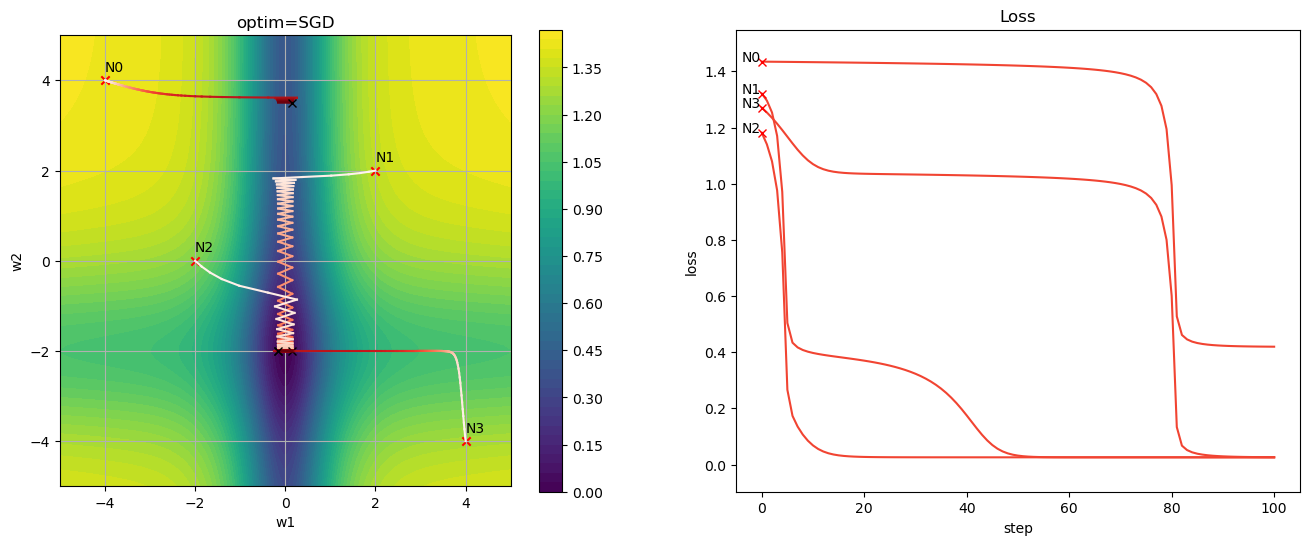

In [82]:
start_w = torch.tensor([[-4.0, 4.0],\
                   [2.0, 2.0],
                   [-2.0, 0.0],
                   [4.0, -4.0]])


lr = 1.0
opt_dict = {'SGD': torch.optim.SGD}
opt_pdict = {'SGD': {'lr': lr}}

history_dict = validate_optimizers(opt_dict=opt_dict,\
                              loss=loss,
                              initial_points=start_w,
                              opt_pdict=opt_pdict,
                              nsteps=100) 

style_dict = {}
style_dict['SGD'] = {'cmap': 'Reds', 'marker': 'x', 'line': '-'}

total_plot(history_dict=history_dict,\
           style_dict=style_dict,
           start_w=start_w)

Видим, что даже для довольно простой функции ошибки не из всех начальных точек SGD одинаково легко достичь глобального минимума.

## 1.1. Momentum, или скатывание тяжелого мяча

### 1.1.1 Мomentum

Вспомним нашу физическую аналогию. Функция ошибки - это силовой потенциал, в котором движется частица (мяч, человек, беспилотник - что угодно):
$$ 
U = \texttt{loss}(\bar{w})
$$
Веса `w` определяют положение этой точки. Сила, действующая на точку:
$$
F^{\bar{w}} = -\nabla_{\bar{w}} U = -\nabla_{\bar{w}} \texttt{loss}
$$
Мы знаем, что в действительности работает ньютоновская механика (сила равна ускорению):
$$
\frac{\partial^2}{\partial t^2}\bar{w} = F^{\bar{w}}
$$
Но для целей оптимизации функции нам поначалу достаточно было "аристотелевского" приближения (сила равна скорости):
$$
\frac{\partial}{\partial t}\bar{w} = F^{\bar{w}}
$$
Формула обновления была такой (метод Эйлера):
$$
\bar{w}_{t+1} \, \mathrel{+}= \texttt{lr} \cdot F^{\bar{w}} = - \texttt{lr}\cdot\nabla_{\bar{w}} \texttt{loss} \big|_{\bar{w}_t}
$$
В этой формуле и кроется фундаментальная уязвимость обычного градиентного спуска - если сила равна нулю, скорость равна нулю - частица останавливается.

В реальности это не так - если бросить мяч, он будет лететь, даже когда сила руки на него уже не действует. Это происходит благодаря *инерции*, которая выражается в наличии у частицы импульса. Фактически, мы теперь используем ньютоновскую механику для частицы единичной массы в потенциале $U$:
$$
\frac{\partial}{\partial t} \bar{p} = F^{\bar{w}} = - \nabla_{\bar{w}}\texttt{loss} \\
\frac{\partial}{\partial t} \bar{w} = \bar{p}
$$
Решение (по методу Эйлера):
$$
\bar{p}_t = \mu \bar{p}_{t-1} - \nabla_{\bar{w}}\texttt{loss} \big|_{\bar{w}_t}\\
\bar{w}_{t+1} \, \mathrel{+}=  \bar{p}_t
$$
Здесь с помощью параметра $\mu\neq 1$ мы ввели диссипацию энергии (затухание) - ведь мы хотим, чтобы "мяч" в итоге остановился в минимуме, а не осциллировал около него.

Идея метода довольно простая, даже странно, что впервые он появился только в 1964 году в работе советского математика Бориса Поляка (в контексте оптимизации функций)

In [57]:
class Momentum(torch.optim.Optimizer):

    def __init__(self, params, lr=3e-4, mu=0.9):

        defaults = {'lr':lr, 'mu':mu}
        super(Momentum, self).__init__(params, defaults)

    def step(self, closure=None):

        for group in self.param_groups:

            lr = group['lr']
            mu = group['mu']

            for param in group['params']:

                if param.grad is None:
                    continue
                
                state = self.state[param]
                
                if 'momentum' not in state:
                    state['momentum'] = torch.zeros_like(param.data)

                state['momentum'] *= mu
                state['momentum'] -= param.grad.data
                param.data += lr*state['momentum']


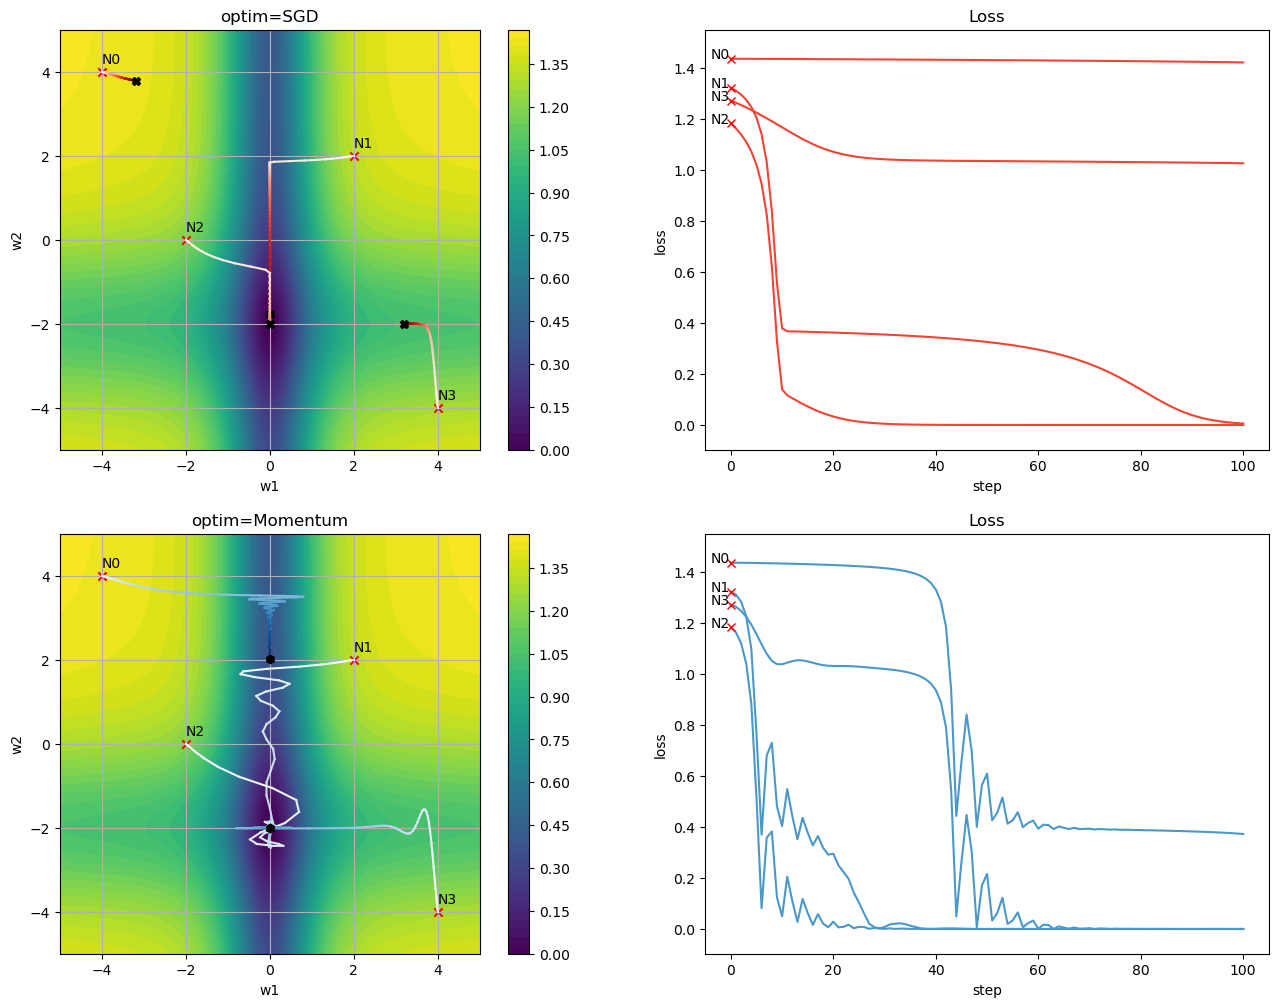

In [85]:
start_w = torch.tensor([[-4.0, 4.0],\
                   [2.0, 2.0],
                   [-2.0, 0.0],
                   [4.0, -4.0]])

opt_dict = {'SGD': torch.optim.SGD,
            'Momentum': Momentum}

lr = 0.5
mu = 0.8
opt_pdict = {'SGD': {'lr': lr},
              'Momentum': {'lr': lr, 'mu': mu}}

opt_hist = validate_optimizers(opt_dict=opt_dict,\
                               loss=loss,
                               initial_points=start_w,
                               opt_pdict=opt_pdict,
                               nsteps=100) 

style_dict = {}
style_dict['SGD'] = {'cmap': 'Reds', 'marker': 'X', 'line': '-'}
style_dict['Momentum'] = {'cmap': 'Blues', 'ls':'-', 'marker':'h'}

total_plot(opt_hist, style_dict, start_w)

Отметим следующие наблюдения:
1. Шаг обновления стал немного дороже - появились дополнительные вычисления;
2. Минимум достигается за такое же или меньшее число шагов;
3. Минимум стал в принципе достижим из точки N3 при данных `lr` и `nsteps`;
4. С учётом 1-3, весь алгоритм стал стабильнее и эффективнее, т.к. 1 шаг forward+backward pass обычно намного дороже любых дополнительных расчётов.

### 1.1.2 Nesterov

Метод моментов можно существенно улучшить за счёт техники `look ahead`, часто используемой в вычислительной математике - заглядывание вперёд по вектору обновления.

Этот метод разработан Юрием Нестеровым в 1984 г. и активно применялся до 2010-х

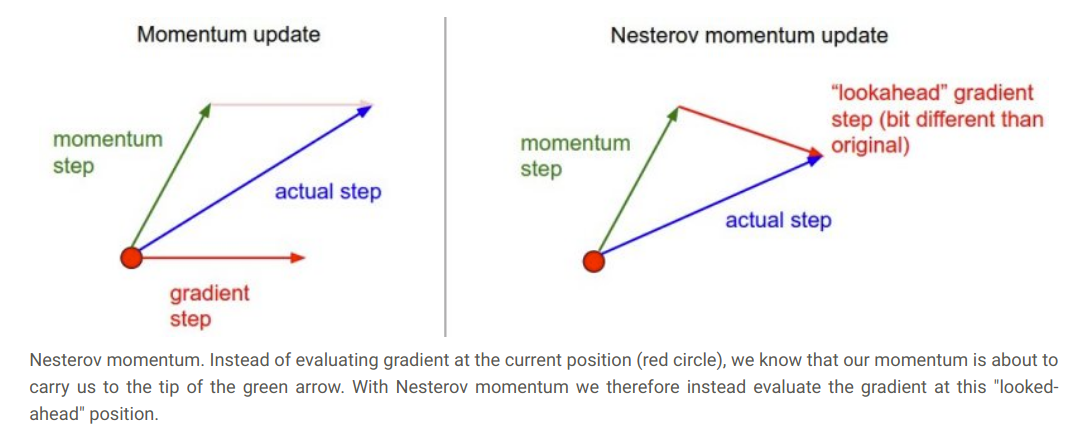

In [86]:
class Nesterov(torch.optim.Optimizer):

    def __init__(self, params, lr=3e-4, mu=0.9):

        defaults = {'lr':lr, 'mu':mu}
        super(Nesterov, self).__init__(params, defaults)

    def step(self, closure=None):

        for group in self.param_groups:

            lr = group['lr']
            mu = group['mu']

            for param in group['params']:

                if param.grad is None:
                    continue
                
                state = self.state[param]
                
                if 'momentum' not in state:
                    state['momentum'] = torch.zeros_like(param.data)

                state['momentum'] *= mu
                state['momentum'] -= param.grad.data
                param.data += lr*(mu*state['momentum'] - param.grad.data)


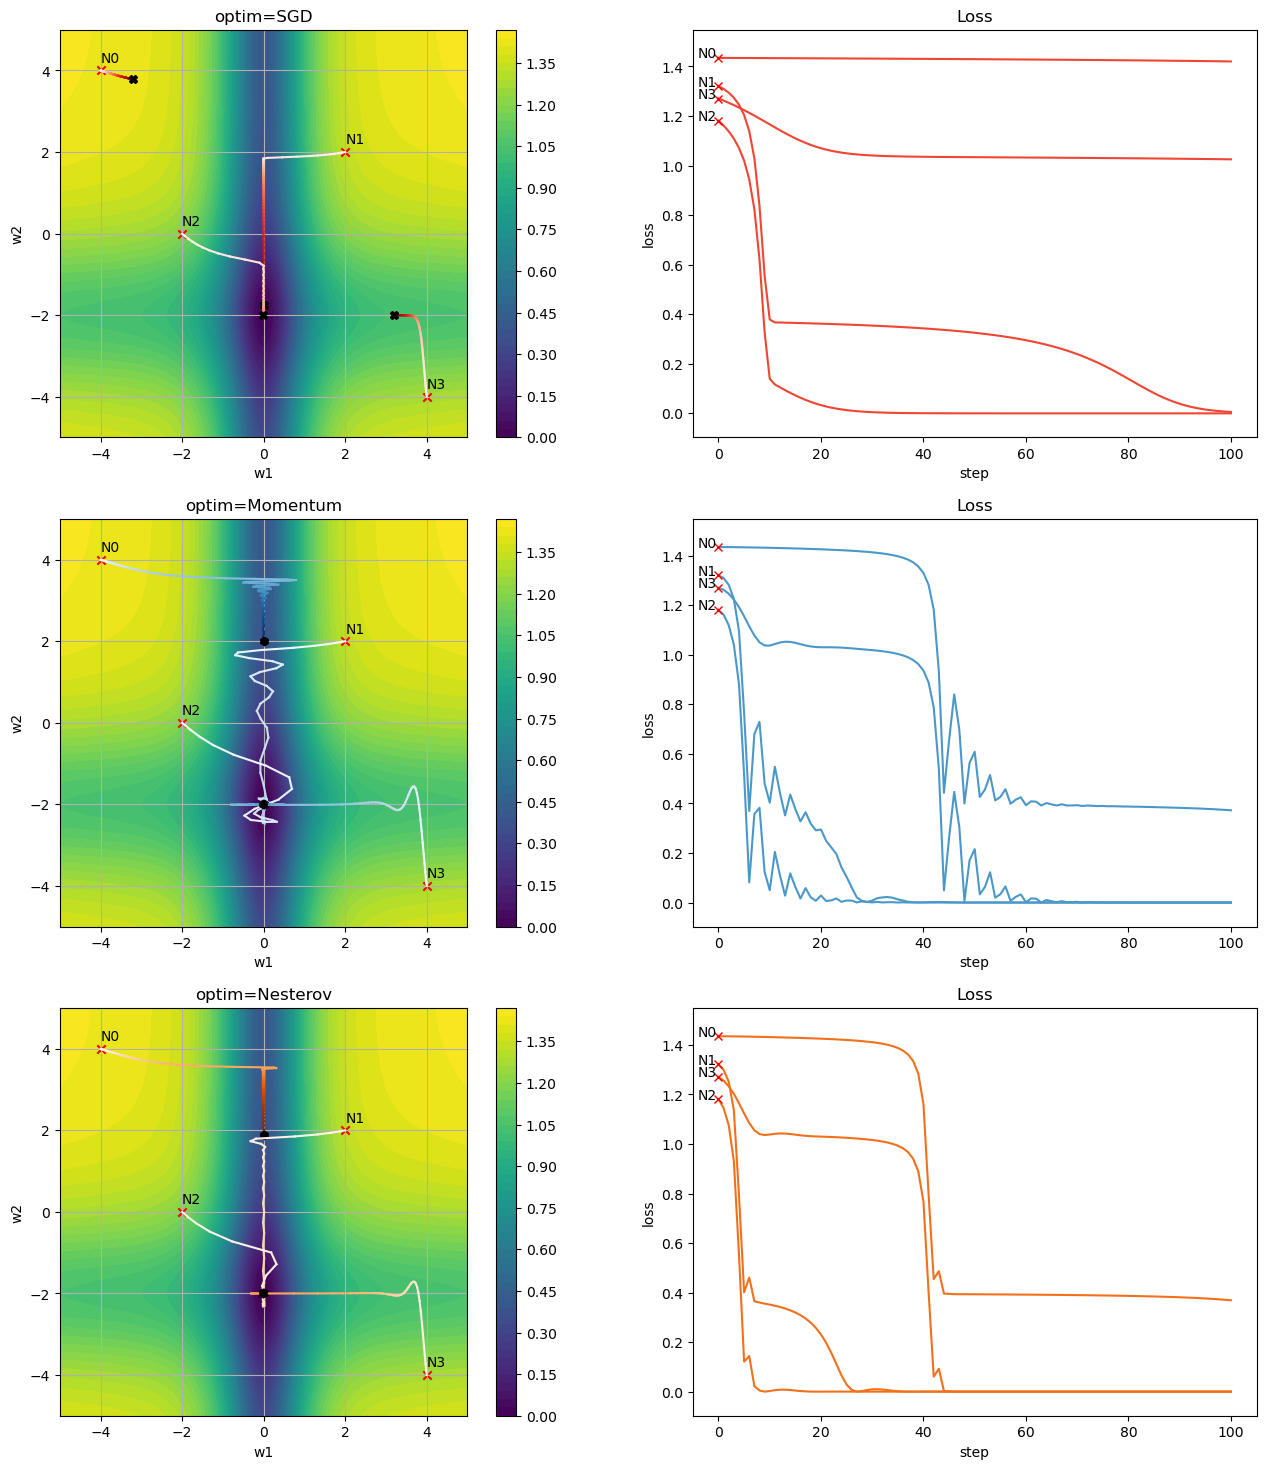

In [87]:
lr = 0.5
mu = 0.8

opt_dict = {'SGD': torch.optim.SGD,
            'Momentum': Momentum,
            'Nesterov': Nesterov}

opt_pdict = {'SGD': {'lr': lr},
              'Momentum': {'lr': lr, 'mu': mu},
              'Nesterov': {'lr': lr, 'mu': mu}}

opt_hist = validate_optimizers(opt_dict=opt_dict,\
                               loss=loss,
                               initial_points=start_w,
                               opt_pdict=opt_pdict,
                               nsteps=100) 

style_dict = {}
style_dict['SGD'] = {'cmap': 'Reds', 'marker': 'X', 'line': '-'}
style_dict['Momentum'] = {'cmap': 'Blues', 'ls':'-', 'marker':'h'}
style_dict['Nesterov'] = {'cmap': 'Oranges', 'ls':'-', 'marker':'h'}

total_plot(opt_hist, style_dict, start_w)

## 1.2 Адаптивные методы


Методы, которые мы сейчас рассмотрели, всё ещё сильно зависят от того, насколько удачно выбран параметр `lr`.

В реальных задачах веса нейросети ведут себя по-разному: на какие-то веса часто приходят большие градиенты, на какие-то в большинстве случаев приходят околонулевые - т.н.  `sparse parameters`. Нужно выставлять соответствующий этому обстоятельству `lr` на каждый вес, но заранее его не угадать, да и не получится подобрать вручную $10^6$ и более параметров.

Как автоматически подбирать `lr` соответственно весу?

### 1.2.1 Adagrad

Adagrad = Adaptive Gradient

Первая и очевидная идея - накапливать какую-нибудь норму пришедших на вес градиентов и использовать её для регулировки `lr` локально, например, по следующей формуле:
$$
{\texttt{gnorm}}_{t+1} = \texttt{gnorm}_{t} + \big| \nabla_{\bar{w}}\texttt{loss} |_{\bar{w}_t} \big|^2 \\
\bar{w}_{t+1} \mathrel{+}= \nabla_{\bar{w}}\texttt{loss} |_{\bar{w}_t} \cdot \frac{\texttt{lr}}{\sqrt{\texttt{gnorm}_t} + \epsilon}
$$
Год создания этого метода - 2011: Duchi, John; Hazan, Elad; Singer, Yoram (2011). "Adaptive subgradient methods for online learning and stochastic optimization"

In [63]:
class Adagrad(torch.optim.Optimizer):

    def __init__(self, params, lr=3e-4, eps=1e-4):

        defaults = {'lr':lr, 'eps': eps}
        super(Adagrad, self).__init__(params, defaults)

    def step(self, closure=None):

        for group in self.param_groups:

            lr = group['lr']
            eps = group['eps']

            for param in group['params']:

                if param.grad is None:
                    continue
                
                state = self.state[param]
                
                if 'gnorm' not in state:
                    state['gnorm'] = torch.zeros_like(param.data)

                state['gnorm'] += torch.pow(param.grad.data, 2)
                param.data += (-lr)*param.grad.data/(torch.sqrt(state['gnorm'])+eps)


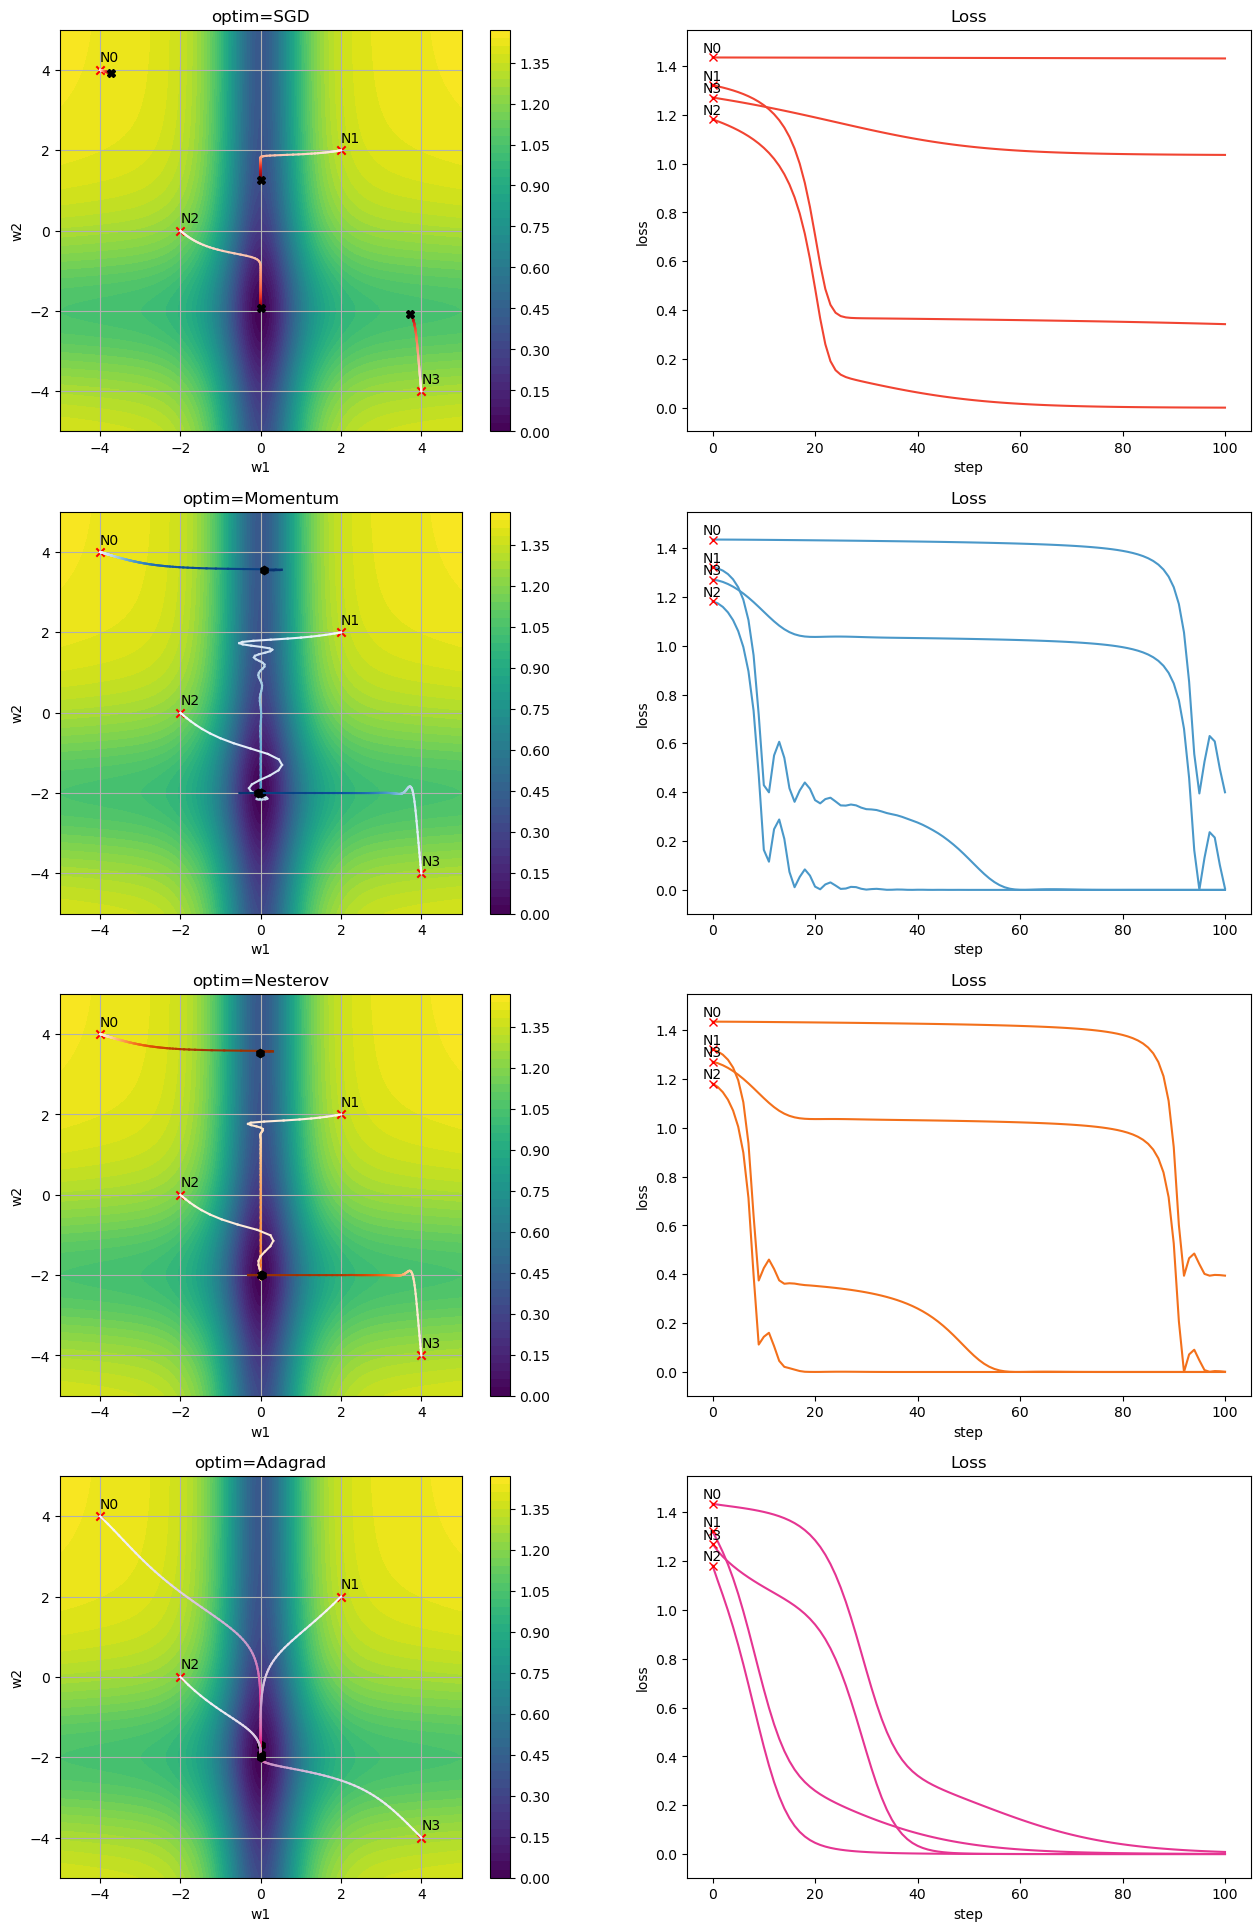

In [65]:
lr = 0.2

opt_dict = {'SGD': torch.optim.SGD,
            'Momentum': Momentum,
            'Nesterov': Nesterov,
            'Adagrad': Adagrad}

opt_pdict = {'SGD': {'lr': lr},
             'Momentum': {'lr': lr, 'mu': 0.8},
             'Nesterov': {'lr': lr, 'mu': 0.8},
             'Adagrad': {'lr': lr}}

opt_hist = validate_optimizers(opt_dict=opt_dict,\
                               loss=loss,
                               initial_points=start_w,
                               opt_pdict=opt_pdict,
                               nsteps=100) 


style_dict = {}
style_dict['SGD'] = {'cmap': 'Reds', 'marker': 'X', 'line': '-'}
style_dict['Momentum'] = {'cmap': 'Blues', 'ls':'-', 'marker':'h'}
style_dict['Nesterov'] = {'cmap': 'Oranges', 'ls':'-', 'marker':'h'}
style_dict['Adagrad'] = {'cmap': 'PuRd', 'ls':'-', 'marker':'h'}

total_plot(opt_hist, style_dict, start_w)

### 1.2.2 RMSProp

RMSprop = Root Mean Square Propagation

Следующая простая идея - не просто суммировать нормы градиентов, а брать скользящее среднее:
$$
{\texttt{gnorm}}_{t+1} = \gamma\cdot\texttt{gnorm}_{t} + (1-\gamma)\cdot\big| \nabla_{\bar{w}}\texttt{loss} |_{\bar{w}_t} \big|^2 \\
\bar{w}_{t+1} \mathrel{+}= \nabla_{\bar{w}}\texttt{loss} |_{\bar{w}_t} \cdot \frac{\texttt{lr}}{\sqrt{\texttt{gnorm}_t} + \epsilon}
$$
Метод придуман в 2012 в научной группе Джеффри Хинтона, и нигде не опубликован: впервые он был представлен в лекции на Coursera

In [66]:
class RMSprop(torch.optim.Optimizer):

    def __init__(self, params, lr=3e-4, eps=1e-4, gma=0.9):

        defaults = {'lr':lr, 'eps': eps, 'gma': gma}
        super(RMSprop, self).__init__(params, defaults)

    def step(self, closure=None):

        for group in self.param_groups:

            lr = group['lr']
            eps = group['eps']
            gma = group['gma']
            gma_ = 1-gma

            for param in group['params']:

                if param.grad is None:
                    continue
                
                state = self.state[param]
                
                if 'gnorm' not in state:
                    state['gnorm'] = torch.zeros_like(param.data)

                state['gnorm'] = state['gnorm']*gma + torch.pow(param.grad.data, 2)*gma_
                param.data += (-lr)*param.grad.data/(torch.sqrt(state['gnorm'])+eps)


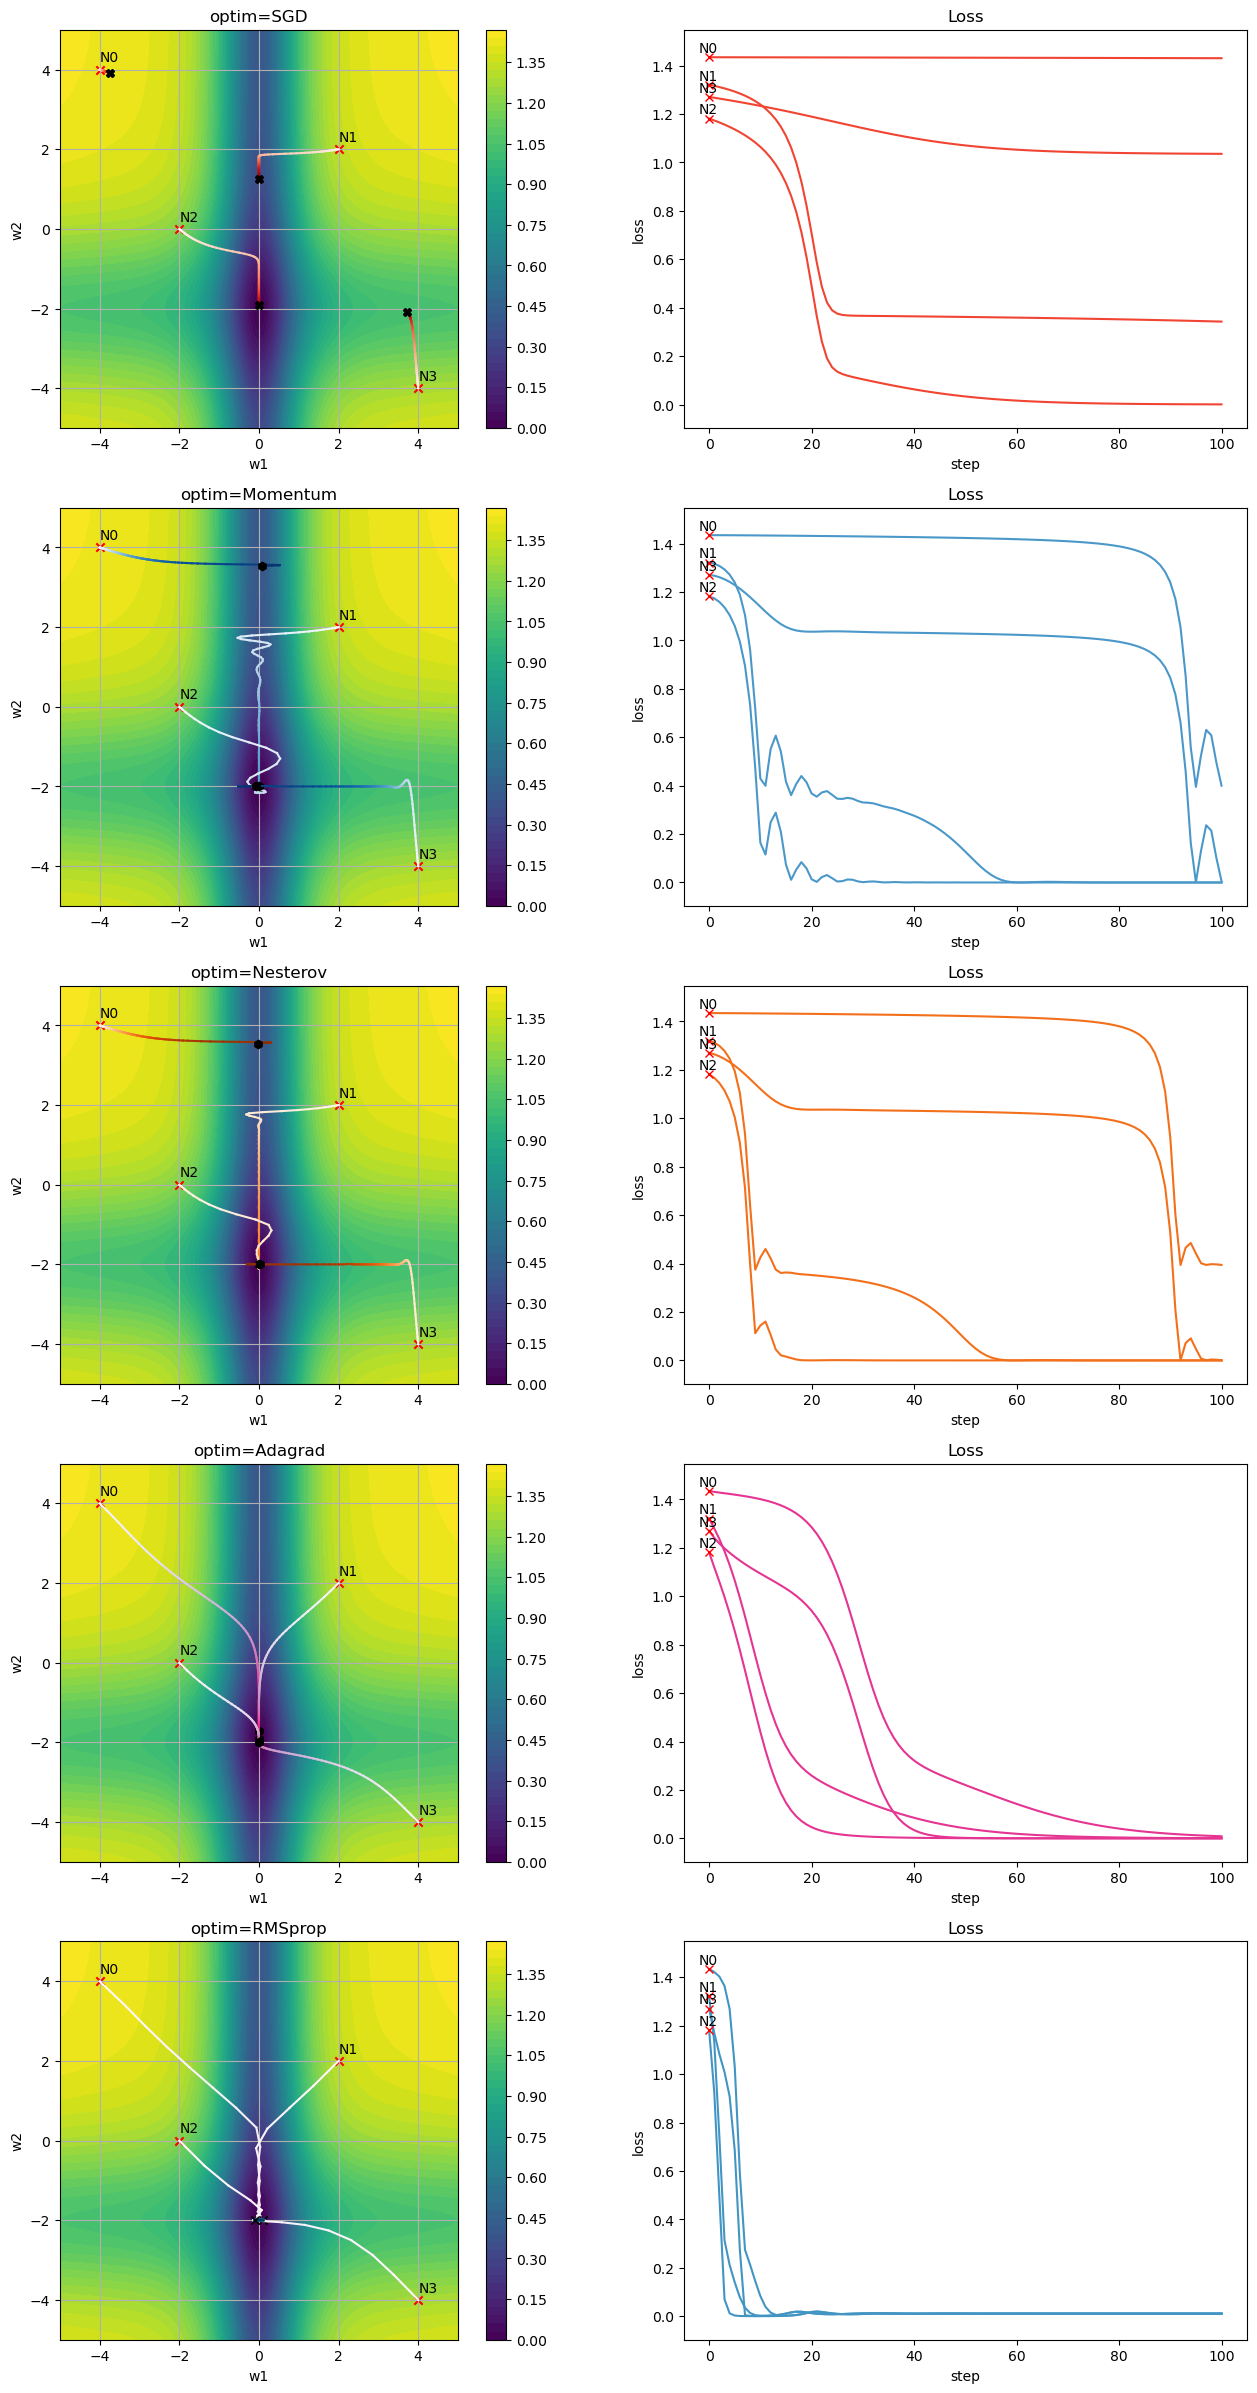

In [ ]:
lr = 0.2
mu = 0.8

opt_dict = {'SGD': torch.optim.SGD,
            'Momentum': Momentum,
            'Nesterov': Nesterov,
            'Adagrad': Adagrad,
            'RMSprop': RMSprop}

opt_pdict = {'SGD': {'lr': lr},
             'Momentum': {'lr': lr, 'mu': mu},
             'Nesterov': {'lr': lr, 'mu': mu},
             'Adagrad': {'lr': lr}, 
             'RMSprop': {'lr': lr}}

opt_hist = validate_optimizers(opt_dict=opt_dict,\
                               loss=loss,
                               initial_points=start_w,
                               opt_pdict=opt_pdict,
                               nsteps=100) 


style_dict = {}
style_dict['SGD'] = {'cmap': 'Reds', 'marker': 'X', 'line': '-'}
style_dict['Momentum'] = {'cmap': 'Blues', 'ls':'-', 'marker':'h'}
style_dict['Nesterov'] = {'cmap': 'Oranges', 'ls':'-', 'marker':'h'}
style_dict['Adagrad'] = {'cmap': 'PuRd', 'ls':'-', 'marker':'h'}
style_dict['RMSprop'] = {'cmap': 'PuBu', 'ls':'-', 'marker':'x'}

total_plot(opt_hist, style_dict, start_w)

### 1.2.3. Adam

Adam = Adaptive Moment Estimation

Естественно, перечисленные идеи можно и нужно совместить в одном методе - это было сделано в 2014 году.


In [ ]:
class Adam(torch.optim.Optimizer):

    def __init__(self, params, lr=3e-4, mu=0.9, eps=1e-4, gma=0.9, nesterov=False):

        defaults = {'lr':lr, 'mu':mu, 'eps': eps, 'gma': gma, 'nesterov': nesterov}
        super(Adam, self).__init__(params, defaults)

    def step(self, closure=None):

        for group in self.param_groups:

            lr = group['lr']
            eps = group['eps']
            gma = group['gma']
            mu = group['mu']
            nesterov = group['nesterov']
            gma_ = 1-gma

            for param in group['params']:

                if param.grad is None:
                    continue
                
                state = self.state[param]

                # YOUR CODE


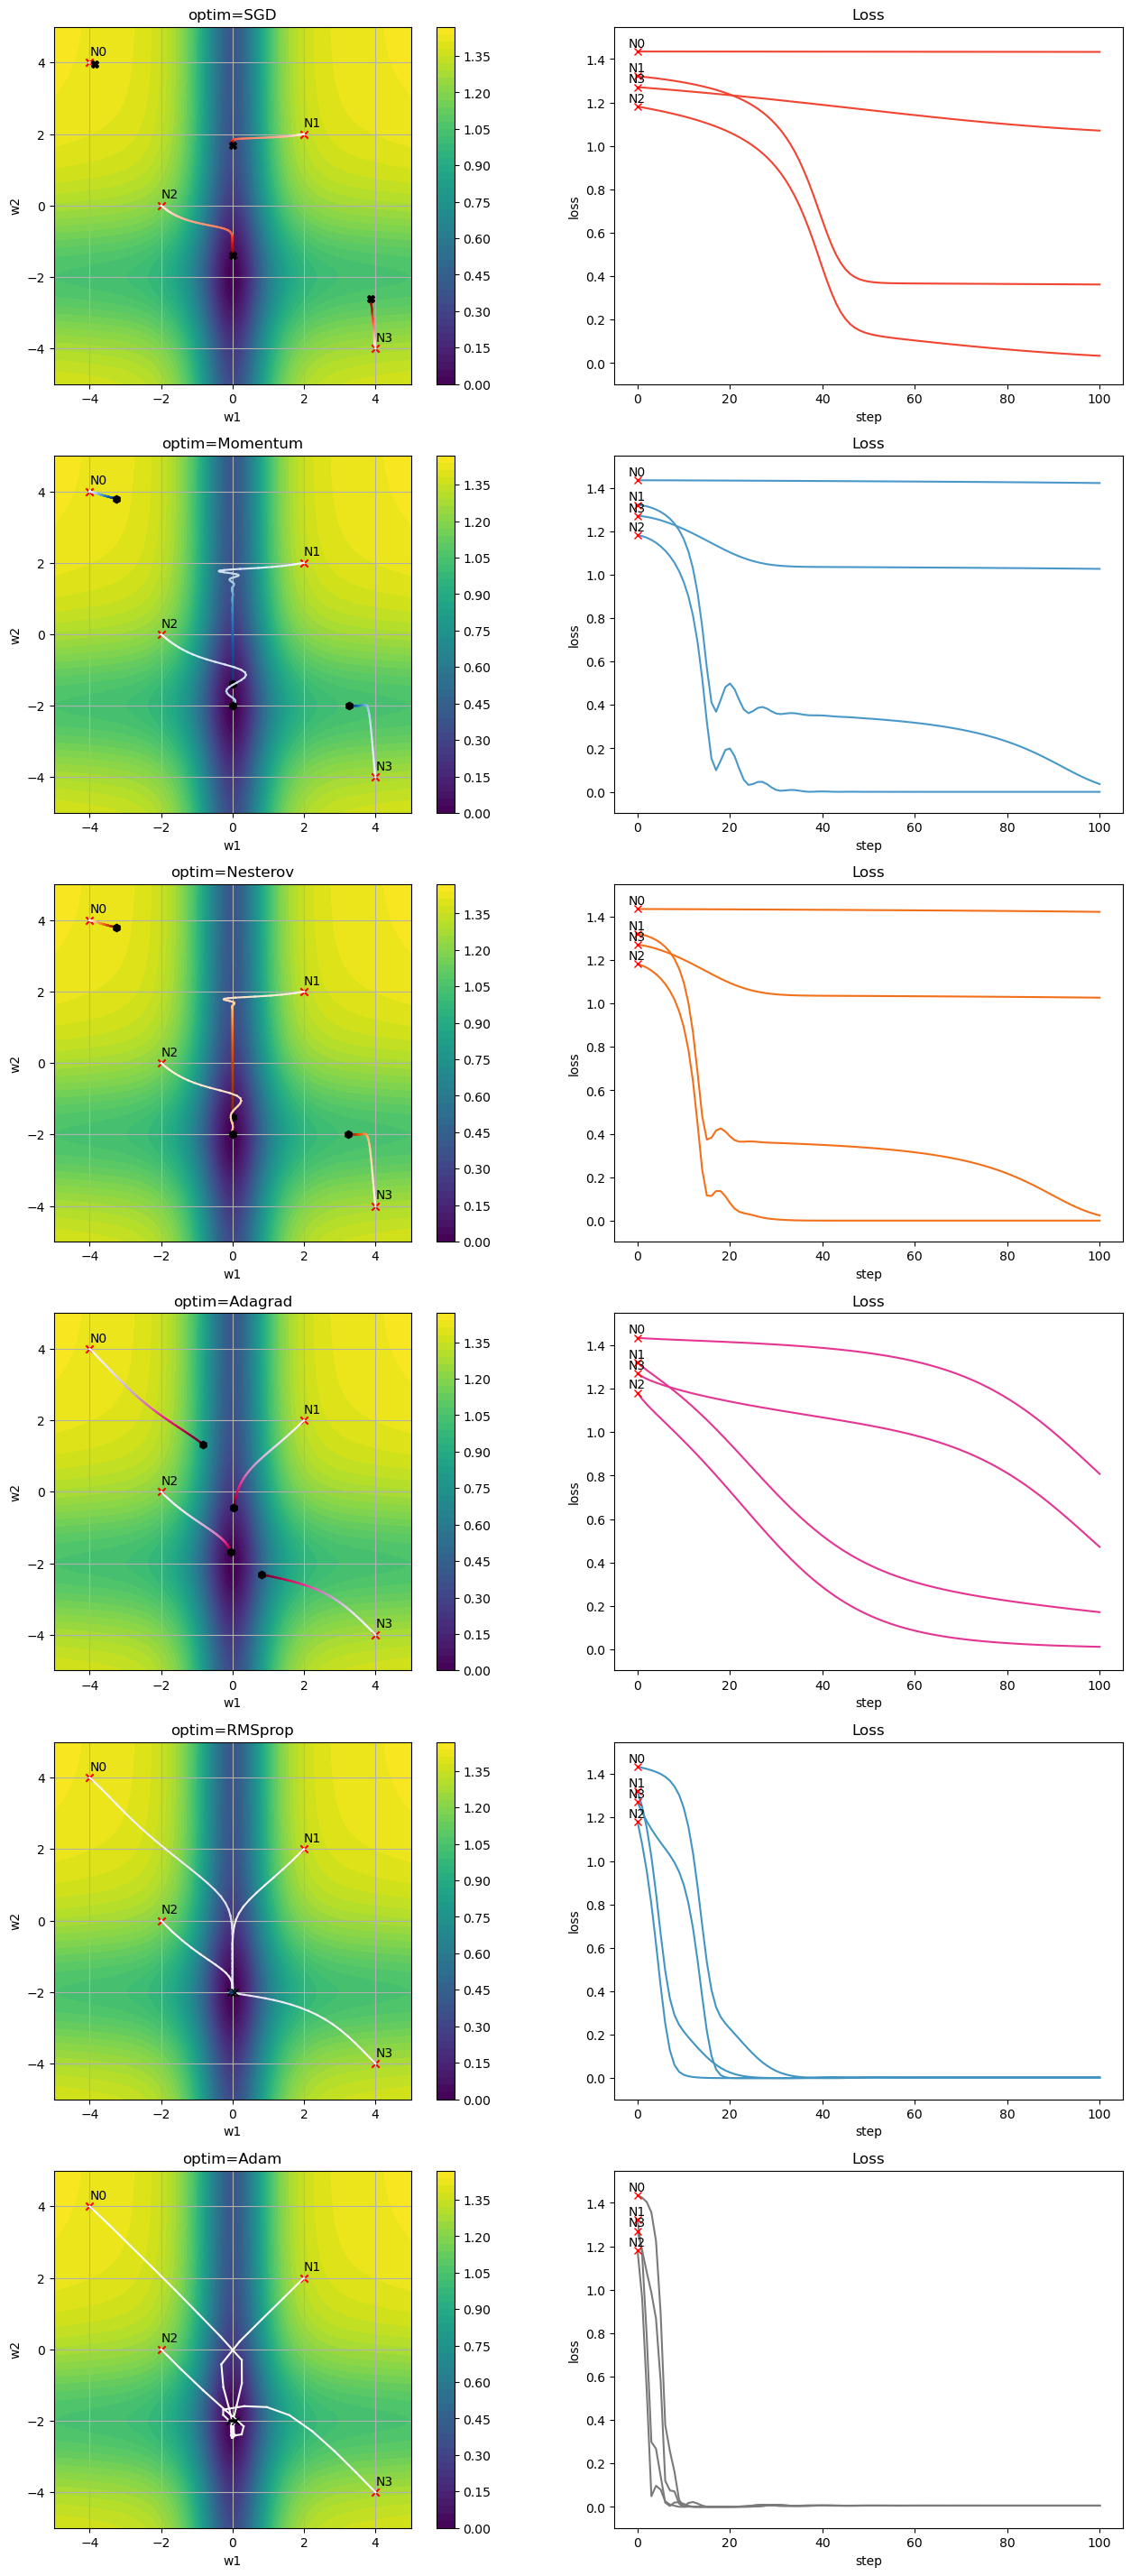

In [72]:
lr = 0.1
mu = 0.8

opt_dict = {'SGD': torch.optim.SGD,
            'Momentum': Momentum,
            'Nesterov': Nesterov,
            'Adagrad': Adagrad,
            'RMSprop': RMSprop,
            'Adam': Adam}

opt_pdict = {'SGD': {'lr': lr},
             'Momentum': {'lr': lr, 'mu': mu},
             'Nesterov': {'lr': lr, 'mu': mu},
             'Adagrad': {'lr': lr}, 
             'RMSprop': {'lr': lr},
             'Adam': {'lr': lr, 'mu': 0.8, 'nesterov': True}}

opt_hist = validate_optimizers(opt_dict=opt_dict,\
                               loss=loss,
                               initial_points=start_w,
                               opt_pdict=opt_pdict,
                               nsteps=100) 

style_dict = {}
style_dict['SGD'] = {'cmap': 'Reds', 'marker': 'X', 'line': '-'}
style_dict['Momentum'] = {'cmap': 'Blues', 'ls':'-', 'marker':'h'}
style_dict['Nesterov'] = {'cmap': 'Oranges', 'ls':'-', 'marker':'h'}
style_dict['Adagrad'] = {'cmap': 'PuRd', 'ls':'-', 'marker':'h'}
style_dict['RMSprop'] = {'cmap': 'PuBu', 'ls':'-', 'marker':'x'}
style_dict['Adam'] = {'cmap': 'Greys', 'ls':'-', 'marker':'x'}

total_plot(opt_hist, style_dict, start_w)

### 1.3. Финальный пример - очень плохая функция ошибки



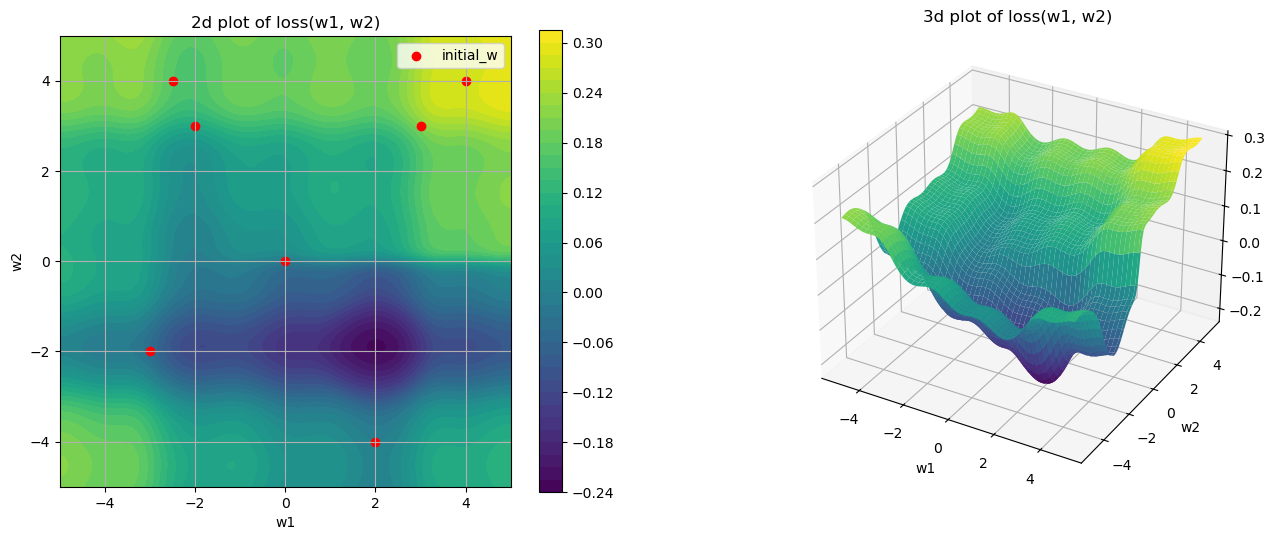

In [88]:
def loss(w):

    x = w[..., 0]
    y = w[..., 1]

    s_y = torch.sigmoid(10*y)

    borders = torch.sigmoid(4*(abs(x)-3)) + torch.sigmoid(4*(abs(y)-3))
    plato1 = torch.sigmoid(x+0.7*y)
    minima = -torch.exp(-torch.cosh((x-2)**2 + (y+2)**2))
    plato2 = -torch.sigmoid(x)-torch.exp(-(y+2)**2)
    osc = torch.cos(torch.pi*(x-1))*0.1+torch.sin(torch.pi*(y-1))*0.06
    outp = borders + (minima+plato2)*(1-s_y) + plato1*s_y + osc

    return torch.tanh(outp/10)

start_w = torch.tensor([(4.0, 4.0), (3.0, 3.0), (-2.5, 4.0), (-2.0, 3.0), (-3.0, -2.0), (0.0, 0.0), (2.0, -4.0)])

w1 = torch.linspace(-5, 5, 100)
w2 = torch.linspace(-5, 5, 100)
w1, w2 = torch.meshgrid(w1, w2, indexing='ij')
W_grid = torch.stack([w1, w2], dim=-1)
Z = loss(W_grid)


fig = plt.figure(figsize=(16, 6))

ax2d = fig.add_subplot(1, 2, 1)
ax2d.set_title('2d plot of loss(w1, w2)')

ax3d = fig.add_subplot(1, 2, 2, projection='3d')
ax3d.set_title('3d plot of loss(w1, w2)')

plot_surface(W_grid, Z, ax2d=ax2d, ax3d=ax3d)

ax2d.scatter(start_w[:, 0], start_w[:, 1], color='red', label='initial_w')
ax2d.legend()

plt.show()

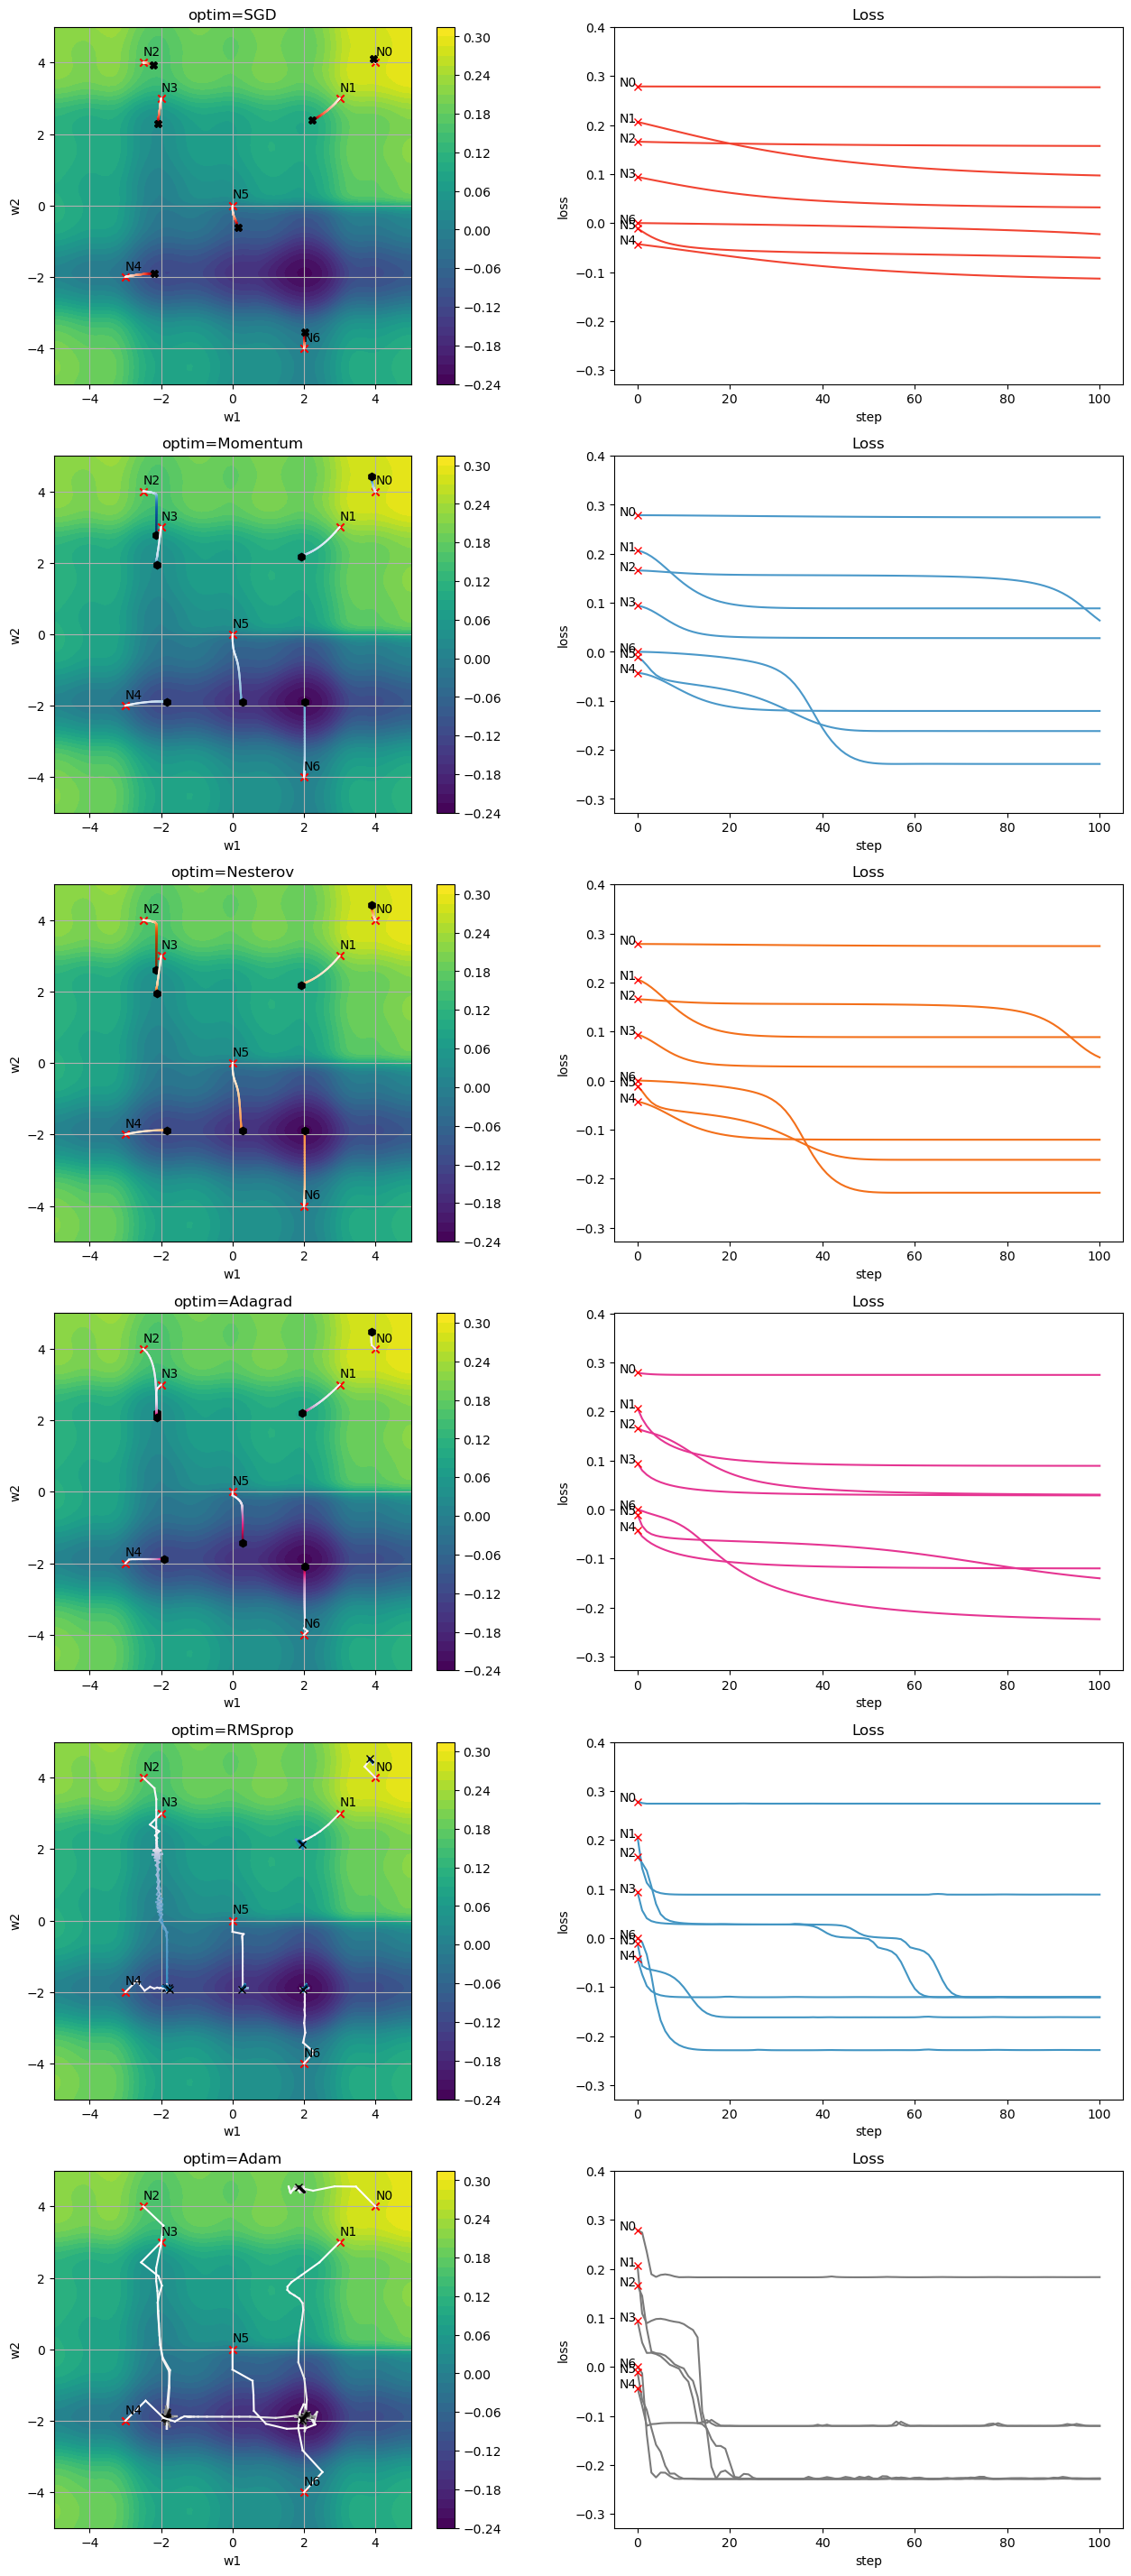

In [89]:
lr = 0.1
mu = 0.8

opt_dict = {'SGD': torch.optim.SGD,
            'Momentum': Momentum,
            'Nesterov': Nesterov,
            'Adagrad': Adagrad,
            'RMSprop': RMSprop,
            'Adam': Adam}

opt_pdict = {'SGD': {'lr': lr},
             'Momentum': {'lr': lr, 'mu': mu},
             'Nesterov': {'lr': lr, 'mu': mu},
             'Adagrad': {'lr': lr}, 
             'RMSprop': {'lr': lr},
             'Adam': {'lr': lr, 'mu': 0.8, 'nesterov': True}}

opt_hist = validate_optimizers(opt_dict=opt_dict,\
                               loss=loss,
                               initial_points=start_w,
                               opt_pdict=opt_pdict,
                               nsteps=100) 

style_dict = {}
style_dict['SGD'] = {'cmap': 'Reds', 'marker': 'X', 'line': '-'}
style_dict['Momentum'] = {'cmap': 'Blues', 'ls':'-', 'marker':'h'}
style_dict['Nesterov'] = {'cmap': 'Oranges', 'ls':'-', 'marker':'h'}
style_dict['Adagrad'] = {'cmap': 'PuRd', 'ls':'-', 'marker':'h'}
style_dict['RMSprop'] = {'cmap': 'PuBu', 'ls':'-', 'marker':'x'}
style_dict['Adam'] = {'cmap': 'Greys', 'ls':'-', 'marker':'x'}

total_plot(opt_hist, style_dict, start_w)